# Basic introduction to Machine Learning

This notebook is based on the source code from Jan Werth: https://github.com/JanderHungrige/PumpSensor

A detailed description can be read here: https://towardsdatascience.com/lstm-for-predictive-maintenance-on-pump-sensor-data-b43486eb3210 Note that this notebook does things a bit different than the article!

The code was adapted by Jascha Grübel for an in-class exercise. You can find a copy on my personal github: https://github.com/jugdemon/2024_introduction_to_ml


Before working on this notebook, please have a look at the opening slides at X.

## Setting up Python in Jupyter (or Colab or any other binder)

Jupyter ought to run in a separate environment and usually does not use the system installation of python. Packages should be installed within the notebook. More details are available in this article: https://jakevdp.github.io/blog/2017/12/05/installing-python-packages-from-jupyter/

### Package-Installation

TensorFlow is difficult to install and is only compatible with specific versions of python. Currently, the newest supported python version is 3.11. Please setup a python environment with this specific version for your Jupyter

MacOS instructions for pyenv: https://www.timescale.com/blog/jupyter-notebook-tutorial-setup-python-and-jupyter-notebooks-macos/

In [1]:
import sys
sys.version
sys.path

['/content',
 '/env/python',
 '/usr/lib/python310.zip',
 '/usr/lib/python3.10',
 '/usr/lib/python3.10/lib-dynload',
 '',
 '/usr/local/lib/python3.10/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.10/dist-packages/IPython/extensions',
 '/usr/local/lib/python3.10/dist-packages/setuptools/_vendor',
 '/root/.ipython']

We can see that version 3.11 or lower is installed. If you see a newer version, please revert to the installation instructions for pyenv to get 3.11 or below.

Generally, it is recommened to load packages for Jupyter with "!" to ensure that they are isntalled in the pyenv of your Juypter-Lab. Running pip install in the console/terminal may result in an installation in a different pyenv than you expected.

In [2]:
import sys
!{sys.executable} -m pip install --upgrade pip
!{sys.executable} -m pip install requests
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install scikit-learn
!{sys.executable} -m pip install tensorflow

### Importing packages

We are loading all the required packages for our basic introduction to machine learning.

In [3]:
from os.path import exists
import requests
import zipfile
import os
import random

import pprint

import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import cm

import numpy as np
from numpy import savetxt

import tensorflow as tf
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense

from math import sqrt
from abc import ABC, abstractmethod

from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve


### Package configuration

To set the figure width in our notebook to roughly screen width, the following settings are used:

In [4]:
plt.rcParams['figure.figsize'] = [10, 6]

## Randomisation

Many models are strongly dependent on the initialisation. To get reproducible results every time we run this notebook, we fix all possible random number sources.

Note that if you only run the model again and not this cell, you will end up with different results each time you run. You need to fix the randomisation every time before you run your model to get consistent results.

A detailed discussions on what we fix can be fould on StackOverflow: https://stackoverflow.com/questions/32419510/how-to-get-reproducible-results-in-keras

In [5]:
# Seed value
# Apparently you may use different seed values at each stage
seed_value= 1337

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
random.seed(seed_value)

# 3. Set the `numpy` pseudo-random generator at a fixed value
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
tf.random.set_seed(seed_value)
# for later versions:
# tf.compat.v1.set_random_seed(seed_value)



## Data acquistion

The data is available here: https://ga-data-cases.s3.eu-central-1.amazonaws.com/pump_sensor.zip

The data must be located next to the notebook to be loaded into Jupyter.

The following section will automate the data loading for you. For later projects you can adapt this.

### Download data

This notebook can also run on https://mybinder.org/ by opening the github repository. The data needs to be downloaded in the binder to work.

In [6]:
if not exists('pump_sensor.zip'):
    url = 'https://ga-data-cases.s3.eu-central-1.amazonaws.com/pump_sensor.zip'

    response = requests.get(url, stream=True)
    with open('pump_sensor.zip', "wb") as f:
        for chunk in response.iter_content(chunk_size=512):
            if chunk:  # filter out keep-alive new chunks
                f.write(chunk)

### Read data from file

The downloaded data is archived and needs to be unpacked to be loaded as a panda dataframe.

In [7]:
if not exists('pump_sensor.csv'):
    with zipfile.ZipFile('pump_sensor.zip', 'r') as zip_ref:
        zip_ref.extractall()

In [8]:
def read_data_frame(path,variable_columns = slice(2,54)):
    """
    Read CSV file and create panda dataframe and read out the raw data, the variable data and the target data.
    path: Location of CSV file
    variable_columns: indices of columns that are variables
    """
    raw_data=pd.read_csv(path)
    variable_names=raw_data.keys()[variable_columns]
    variable_data = raw_data.iloc[:,variable_columns]
    target_data = raw_data.loc[:,['machine_status']]

    le = preprocessing.LabelEncoder()
    le.fit(target_data['machine_status'])
    encoded_y=le.transform(target_data['machine_status'])
    #Get the Label map
    le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    encoded_target_data =  pd.DataFrame(encoded_y,columns=['target'])

    return raw_data, variable_data, target_data,encoded_target_data

raw_data,variable_data,target_data,encoded_target_data=read_data_frame('pump_sensor.csv')

In [9]:
def scale_data_frame(data):
    scaler = MinMaxScaler()
    scaled_data = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)
    return scaled_data

scaled_data = scale_data_frame(variable_data)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/_array_api.py:769: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmin(X, axis=axis))
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_array_api.py:786: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmax(X, axis=axis))


## Overview of data

Visual inspection of data is a very useful first step.

Later on, the visual understanding of the data can give us an intuition whether what we see with transformed data makes sense or whether we possibly made a mistake.

We see 220320 rows and 55 columns. The keys indicate mostly data columns, a target column and an unnamed column and a timestamp. The target function is categorical and has 3 states (classes). The categories occur at different rates. Normal operation is the most common. Recovering is relatively rare but happens and broken is in the single digits.

In [10]:
def explore_data(data,target_column = "machine_status",variable_columns = slice(2,54)):
    """
    A function to get key characteristics of a data set and return the head, tail and summary statistics of the columns.
    data: dataframe to be inspected
    target_column: target function for prediction
    variable_columns: indices of columns that are variables
    """
    print('Overview: ')
    print(data.shape); print()
    print('Columns:') ; print(data.keys()); print()
    print(target_column +': ');  print( data[target_column].unique()); print()
    print (data[target_column].value_counts()); print()
    return data.head(), data.tail()



head,tail=explore_data(raw_data)

Overview: 
(220320, 55)

Columns:
Index(['Unnamed: 0', 'timestamp', 'sensor_00', 'sensor_01', 'sensor_02',
       'sensor_03', 'sensor_04', 'sensor_05', 'sensor_06', 'sensor_07',
       'sensor_08', 'sensor_09', 'sensor_10', 'sensor_11', 'sensor_12',
       'sensor_13', 'sensor_14', 'sensor_15', 'sensor_16', 'sensor_17',
       'sensor_18', 'sensor_19', 'sensor_20', 'sensor_21', 'sensor_22',
       'sensor_23', 'sensor_24', 'sensor_25', 'sensor_26', 'sensor_27',
       'sensor_28', 'sensor_29', 'sensor_30', 'sensor_31', 'sensor_32',
       'sensor_33', 'sensor_34', 'sensor_35', 'sensor_36', 'sensor_37',
       'sensor_38', 'sensor_39', 'sensor_40', 'sensor_41', 'sensor_42',
       'sensor_43', 'sensor_44', 'sensor_45', 'sensor_46', 'sensor_47',
       'sensor_48', 'sensor_49', 'sensor_50', 'sensor_51', 'machine_status'],
      dtype='object')

machine_status: 
['NORMAL' 'BROKEN' 'RECOVERING']

machine_status
NORMAL        205836
RECOVERING     14477
BROKEN             7
Name: count, dt

In [11]:
def describe_data(data):
    """
    Function to describe highlevel data. Assumes that the data is numerical.
    """
    info=data.describe()
    var=pd.DataFrame({'Var':data.var()})
    info=pd.concat([info,var.transpose()])

    return info

info = describe_data(variable_data)

info_scaled = describe_data(scaled_data)

First, let's inspect the head of the data to see what we got. Note that the sensors are all numeric and that the time starts in April 2018 and the unnamed first column seems to be an index.

In [12]:
head

,Unnamed: 0,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,...,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
0,0,2018-04-01 00:00:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
1,1,2018-04-01 00:01:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
2,2,2018-04-01 00:02:00,2.444734,47.35243,53.2118,46.397570,638.8889,73.54598,13.32465,16.03733,...,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,241.3194,203.7037,NORMAL
3,3,2018-04-01 00:03:00,2.460474,47.09201,53.1684,46.397568,628.1250,76.98898,13.31742,16.24711,...,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,240.4514,203.1250,NORMAL
4,4,2018-04-01 00:04:00,2.445718,47.13541,53.2118,46.397568,636.4583,76.58897,13.35359,16.21094,...,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,242.1875,201.3889,NORMAL


Second, we inspect the tail to see how things are at the end of the data set. We note that the time stops at the end of August 2018 - so 5 months worth of data. We also note that sensor 50 is NaN (Not a Number), so we have some data to clean.

In [13]:
tail

,Unnamed: 0,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,...,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
220315,220315,2018-08-31 23:55:00,2.407350,47.69965,50.520830,43.142361,634.722229,64.59095,15.11863,16.65220,...,38.28125,68.28703,52.37268,48.32176,41.087960,212.3843,153.6458,NaN,231.1921,NORMAL
220316,220316,2018-08-31 23:56:00,2.400463,47.69965,50.564240,43.142361,630.902771,65.83363,15.15480,16.70284,...,38.28125,66.84028,50.63657,48.03241,40.798610,213.8310,156.2500,NaN,231.1921,NORMAL
220317,220317,2018-08-31 23:57:00,2.396528,47.69965,50.520830,43.142361,625.925903,67.29445,15.08970,16.70284,...,39.06250,65.39352,48.90046,48.03241,40.798610,217.3032,155.3819,NaN,232.0602,NORMAL
220318,220318,2018-08-31 23:58:00,2.406366,47.69965,50.520832,43.142361,635.648100,65.09175,15.11863,16.56539,...,40.62500,64.23611,47.74306,48.32176,40.509258,222.5116,153.9352,NaN,234.0856,NORMAL
220319,220319,2018-08-31 23:59:00,2.396528,47.69965,50.520832,43.142361,639.814800,65.45634,15.11863,16.65220,...,41.40625,62.78935,46.29630,48.90046,40.219910,227.4306,150.4630,NaN,234.0856,NORMAL


Third, having seen the raw data, it makes sense to look a bit at the descriptive aggregate of the data. The distribution of unnamed speaks of an index. We see that some sensors have high and some have low variance.

In [14]:
info

,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,...,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51
count,210112.000000,219951.000000,220301.000000,220301.000000,220301.000000,220301.000000,215522.000000,214869.000000,215213.000000,215725.000000,...,220293.000000,220293.000000,220293.000000,220293.000000,220293.000000,220293.000000,220293.000000,220293.000000,143303.000000,204937.000000
mean,2.372221,47.591611,50.867392,43.752481,590.673936,73.396414,13.501537,15.843152,15.200721,14.799210,...,35.453455,43.879591,42.656877,43.094984,48.018585,44.340903,150.889044,57.119968,183.049260,202.699667
std,0.412227,3.296666,3.666820,2.418887,144.023912,17.298247,2.163736,2.201155,2.037390,2.091963,...,10.259521,11.044404,11.576355,12.837520,15.641284,10.442437,82.244957,19.143598,65.258650,109.588607
min,0.000000,0.000000,33.159720,31.640620,2.798032,0.000000,0.014468,0.000000,0.028935,0.000000,...,22.135416,24.479166,25.752316,26.331018,26.331018,27.199070,26.331018,26.620370,27.488426,27.777779
25%,2.438831,46.310760,50.390620,42.838539,626.620400,69.976260,13.346350,15.907120,15.183740,15.053530,...,32.812500,39.583330,36.747684,36.747684,40.509258,39.062500,83.912030,47.743060,167.534700,179.108800
50%,2.456539,48.133678,51.649300,44.227428,632.638916,75.576790,13.642940,16.167530,15.494790,15.082470,...,35.156250,42.968750,40.509260,40.219910,44.849540,42.534720,138.020800,52.662040,193.865700,197.338000
75%,2.499826,49.479160,52.777770,45.312500,637.615723,80.912150,14.539930,16.427950,15.697340,15.118630,...,36.979164,46.614580,45.138890,44.849540,51.215280,46.585650,208.333300,60.763890,219.907400,216.724500
max,2.549016,56.727430,56.032990,48.220490,800.000000,99.999880,22.251160,23.596640,24.348960,25.000000,...,374.218800,408.593700,1000.000000,320.312500,370.370400,303.530100,561.632000,464.409700,1000.000000,1000.000000
Var,0.169931,10.868004,13.445572,5.851012,20742.887193,299.229350,4.681754,4.845085,4.150960,4.376311,...,105.257765,121.978855,134.011998,164.801917,244.649751,109.044492,6764.232920,366.477334,4258.691443,12009.662837


Fourth, we look at the scaled data, because the distribution of raw values may hide how the variance is spread

In [15]:
info_scaled

,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,...,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51
count,210112.000000,219951.000000,220301.000000,220301.000000,220301.000000,220301.000000,215522.000000,214869.000000,215213.000000,215725.000000,...,220293.000000,220293.000000,220293.000000,220293.000000,220293.000000,220293.000000,220293.000000,220293.000000,143303.000000,204937.000000
mean,0.930642,0.838952,0.774164,0.730516,0.737424,0.733965,0.606523,0.671416,0.623839,0.591968,...,0.037826,0.050507,0.017351,0.057024,0.063038,0.062034,0.232688,0.069667,0.159958,0.179920
std,0.161720,0.058114,0.160310,0.145893,0.180662,0.172983,0.097305,0.093283,0.083774,0.083679,...,0.029139,0.028753,0.011882,0.043668,0.045464,0.037790,0.153642,0.043728,0.067103,0.112720
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.956774,0.816373,0.753320,0.675392,0.782515,0.699763,0.599544,0.674126,0.623141,0.602141,...,0.030325,0.039322,0.011286,0.035433,0.041211,0.042932,0.107568,0.048249,0.144005,0.155655
50%,0.963721,0.848508,0.808349,0.759162,0.790064,0.755769,0.612882,0.685162,0.635931,0.603299,...,0.036982,0.048136,0.015147,0.047244,0.053827,0.055497,0.208649,0.059484,0.171080,0.174405
75%,0.980702,0.872226,0.857685,0.824607,0.796307,0.809122,0.653220,0.696199,0.644259,0.604745,...,0.042160,0.057627,0.019899,0.062992,0.072330,0.070157,0.340000,0.077991,0.197858,0.194345
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
Var,0.026153,0.003377,0.025699,0.021285,0.032639,0.029923,0.009468,0.008702,0.007018,0.007002,...,0.000849,0.000827,0.000141,0.001907,0.002067,0.001428,0.023606,0.001912,0.004503,0.012706


## Raw data visualisation

To faciliate the visualisation of the categorical and continuous variables, we create two helper functions. You may reuse these functions.

In [16]:
def plot_continuous_data(data,plot_type,title, save=False,axis = None,without_legend=False,scale_x_limit = True):
    """
    A function to plot a continous variable with various types.
    data: the dataframe to plot.
    plot_type: type of plot in matlibplot.
    title: Title of the graph.
    save: store a png image of the graph.
    axis: axis on which to print the plot instead of a new figure.
    without_legend: removes legend
    scale_x_limit: forces an x range from 0 to the data size to plot data that is NaN as well.
    """
    if axis is None:
        fig=plt.figure()
        axis = plt.gca()

    data.plot(kind=plot_type, ax=axis)
    axis.set_title(title)
    if without_legend:
        axis.get_legend().remove()
    if scale_x_limit:
        axis.set_xlim(0, data.shape[0])
    if save==True:
        plt.savefig(title+'.png', format='png', dpi=300, transparent=True)

    if axis is None:
        fig.tight_layout()

def plot_categorical_data(data, column='target', save=False, name='target', class_order= [1,0,2]):
    """
    A function to plot a categorical variable over time.
    data: the dataframe to plot.
    column: the column with the categorical variable.
    save: store a png image of the graph.
    name: name for png file.
    class_order: arranging the categorical variables.
    """
    y=data[column]; x=np.linspace(1,len(y),len(y))
    plt.plot(x,y)
    plt.ylabel('Class')
    plt.title(column)
    labels = y.unique()
    plt.yticks(class_order, labels, rotation='vertical')
    if save==True:
        plt.savefig(name+'.png', format='png', dpi=300, transparent=True)
    plt.tight_layout()
    plt.show()

### Target function

The target of our prediction is the status of the machine. We inspect the behaviour of the target over time. First, we observe that the status "broken" nearly never appears. With 7 observations, there is no chance to predict it effectively. However, the "recovering" class appears quite often allowing us to predict it.

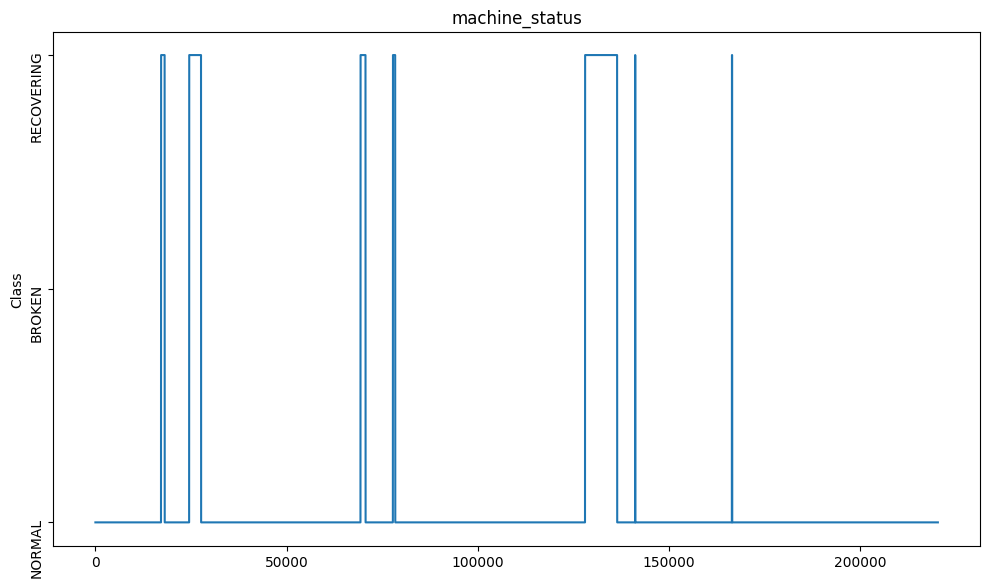

In [17]:
plot_categorical_data(raw_data,column='machine_status',save=False,name='target', class_order= [0,1,2])

### Data quality

A typical problem in machine learning is "Garbage in, garbage out". That is, if a good signal is distorted by noisy data, we will unnecessarily reduce our prediction ability. Before we can dare to use the data for prediction, we need to ensure data quality.

We already noticed NaN in the data inspection. Now it is time look closer.

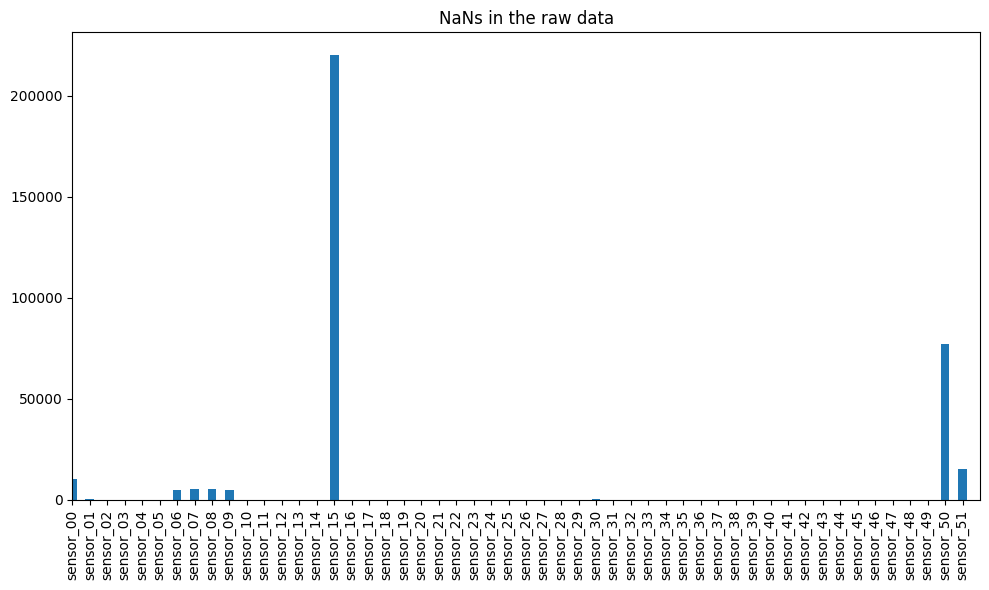

In [18]:
plot_continuous_data((raw_data.isna().sum())[2:-1],'bar','NaNs in the raw data',save=False)
plt.tight_layout()

We observe NaNs in the sensors 00, 06, 07, 08, 09, 15, 50 and 51.

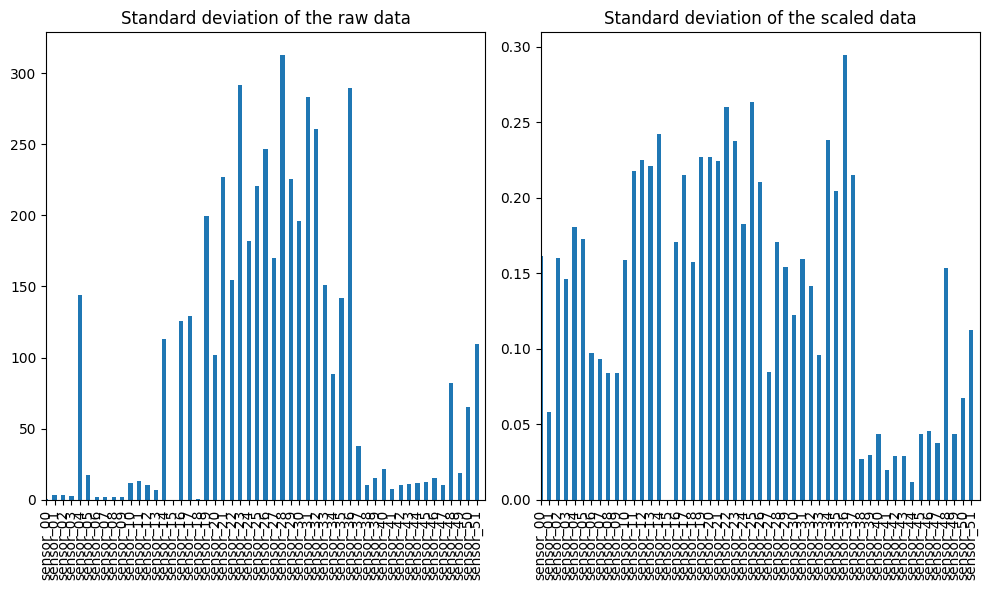

In [19]:
fig, axes = plt.subplots(nrows=1, ncols=2)
plot_continuous_data(info.loc[['std']].transpose(),'bar','Standard deviation of the raw data',without_legend = True, save=False,axis = axes[0])
plot_continuous_data(info_scaled.loc[['std']].transpose(),'bar','Standard deviation of the scaled data',without_legend = True, save=False,axis = axes[1])
plt.tight_layout()

We can see that the columns with NaNs have a very low std in the raw data but substantial std in the scaled data. Only sensor 15 is not contributing. Note that if you had looked only at the unscaled data you might think that some sensors have low variance when they are only on a different scale!

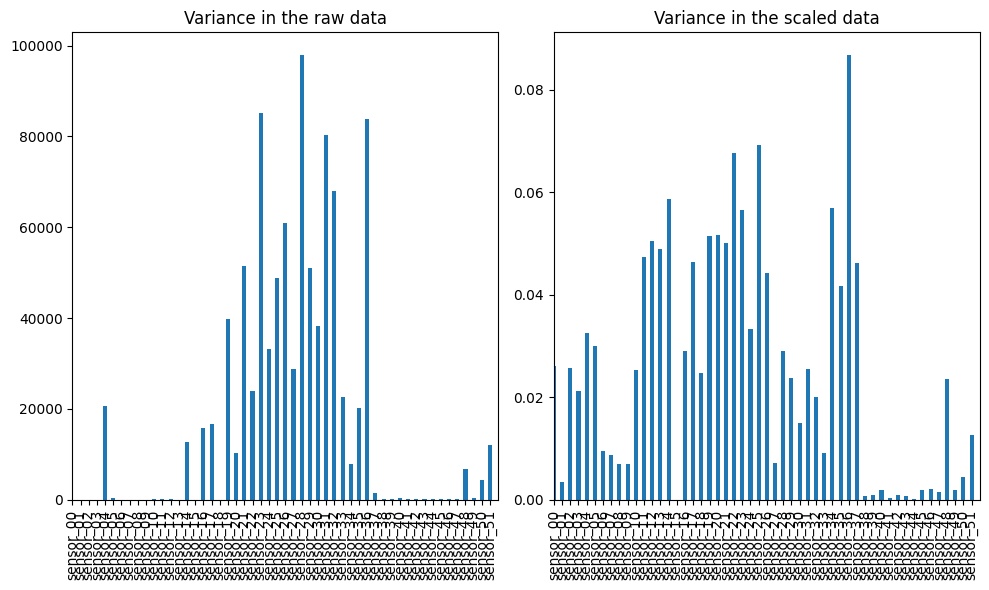

In [20]:
fig, axes = plt.subplots(nrows=1, ncols=2)
plot_continuous_data(info.loc[['Var']].transpose(),'bar','Variance in the raw data',without_legend=True,save=False,axis = axes[0])
plot_continuous_data(info_scaled.loc[['Var']].transpose(),'bar','Variance in the scaled data',without_legend=True,save=False,axis = axes[1])
plt.tight_layout()

Our suspicion from the std is repeated with the variance. It is important to normalise data for this kind of check to make sense.

### Data wrangling

To repair the data, we need to minimize the NaNs to essentially zero. If we would just delete all NaNs rows we would lose most data because sensor 15 has 93% NaNs.

Sensor 15 has a lot of NaNs und no variance and therefore can be dropped.

Let's have a look at the other sensors first with relation to the target function:

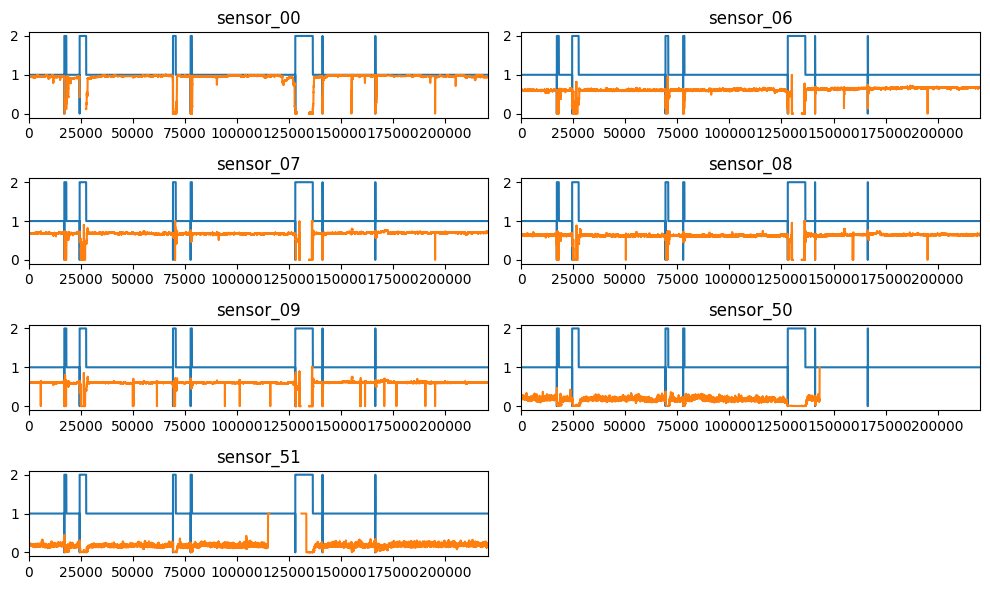

In [21]:
fig, axes = plt.subplots(nrows=4, ncols=2,)
plot_continuous_data(encoded_target_data['target'],'line',"Target",axis = axes[0,0],without_legend = False)
plot_continuous_data(scaled_data['sensor_00'],'line',str('sensor_00'),scale_x_limit=False,axis = axes[0,0])
plot_continuous_data(encoded_target_data['target'],'line',"Target",axis = axes[0,1],without_legend = False)
plot_continuous_data(scaled_data['sensor_06'],'line',str('sensor_06'),scale_x_limit=False,axis = axes[0,1])
plot_continuous_data(encoded_target_data['target'],'line',"Target",axis = axes[1,0],without_legend = False)
plot_continuous_data(scaled_data['sensor_07'],'line',str('sensor_07'),scale_x_limit=False,axis = axes[1,0])
plot_continuous_data(encoded_target_data['target'],'line',"Target",axis = axes[1,1],without_legend = False)
plot_continuous_data(scaled_data['sensor_08'],'line',str('sensor_08'),scale_x_limit=False,axis = axes[1,1])
plot_continuous_data(encoded_target_data['target'],'line',"Target",axis = axes[2,0],without_legend = False)
plot_continuous_data(scaled_data['sensor_09'],'line',str('sensor_09'),scale_x_limit=False,axis = axes[2,0])
plot_continuous_data(encoded_target_data['target'],'line',"Target",axis = axes[2,1],without_legend = False)
plot_continuous_data(scaled_data['sensor_50'],'line',str('sensor_50'),scale_x_limit=False,axis = axes[2,1])
plot_continuous_data(encoded_target_data['target'],'line',"Target",axis = axes[3,0],without_legend = False)
plot_continuous_data(scaled_data['sensor_51'],'line',str('sensor_51'),scale_x_limit=False,axis = axes[3,0])
axes[3,1].set_axis_off()
plt.tight_layout()

We notice that sensors 00, 06, 07, 08, 09 all have NaNs during a recovery phase. We also see that the recovery phase generally drives the value towards 0. So filling the NaNs is sensible. There are up to 10000 time steps without data so we fill NAs up to that value.

Sensors 50 and 51 show a different picture. Sensor 51 seems to have been disconnected for a while whereas sensor 50 went offline. Let's look at them closer together because they exhibit an overall similar pattern.

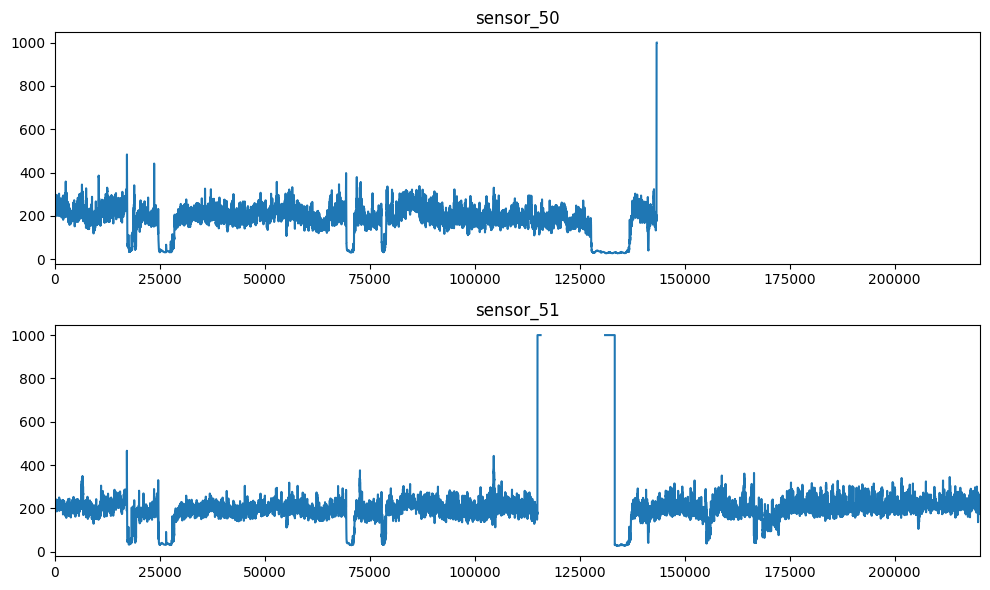

In [22]:
fig, axes = plt.subplots(nrows=2, ncols=1)
plot_continuous_data(variable_data['sensor_50'],'line',str('sensor_50'),axis = axes[0])
plot_continuous_data(variable_data['sensor_51'],'line',str('sensor_51'),axis = axes[1])
plt.tight_layout()

There is data loss between 110000 and 140000 in sensor 51 and total data loss in sensor 50 starting from 145000.

We zoom into the area of interest for a more thorough comparison:

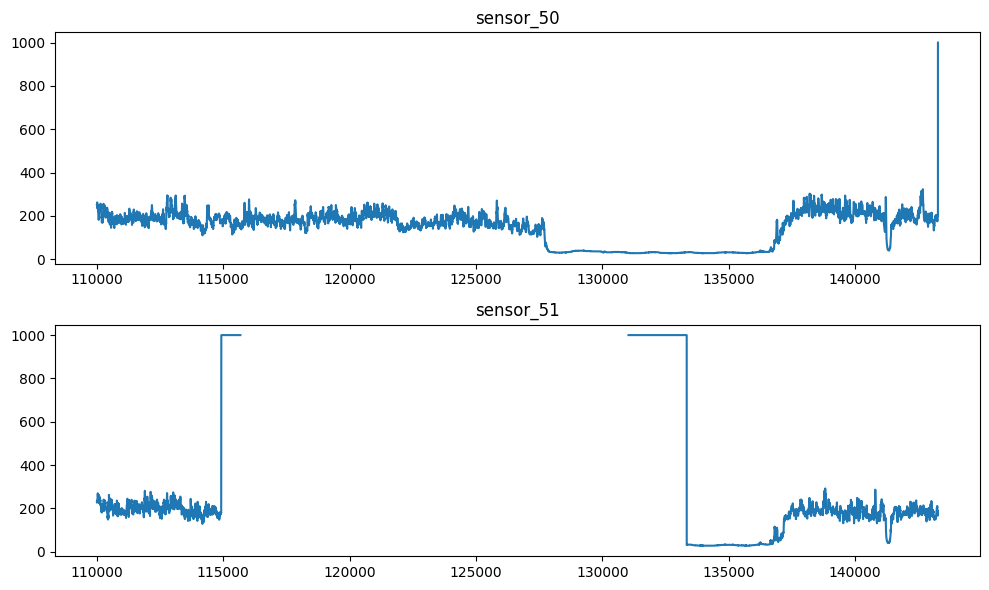

In [23]:
fig, axes = plt.subplots(nrows=2, ncols=1)
plot_continuous_data(variable_data['sensor_50'][110000:143279],'line',str('sensor_50'),axis = axes[0],scale_x_limit=False)
plot_continuous_data(variable_data['sensor_51'][110000:143279],'line',str('sensor_51'),axis = axes[1],scale_x_limit=False)
plt.tight_layout()

Given the high similarity of the signal, we can consider fixing sensor 51 with the data from sensor 50 and drop 50 alltogether.

We create a wrangle function that drops columns, copies data and fills broken data.

sensor_00     10208
sensor_01       369
sensor_02        19
sensor_03        19
sensor_04        19
sensor_05        19
sensor_06      4798
sensor_07      5451
sensor_08      5107
sensor_09      4595
sensor_10        19
sensor_11        19
sensor_12        19
sensor_13        19
sensor_14        21
sensor_15    220320
sensor_16        31
sensor_17        46
sensor_18        46
sensor_19        16
sensor_20        16
sensor_21        16
sensor_22        41
sensor_23        16
sensor_24        16
sensor_25        36
sensor_26        20
sensor_27        16
sensor_28        16
sensor_29        72
sensor_30       261
sensor_31        16
sensor_32        68
sensor_33        16
sensor_34        16
sensor_35        16
sensor_36        16
sensor_37        16
sensor_38        27
sensor_39        27
sensor_40        27
sensor_41        27
sensor_42        27
sensor_43        27
sensor_44        27
sensor_45        27
sensor_46        27
sensor_47        27
sensor_48        27
sensor_49        27


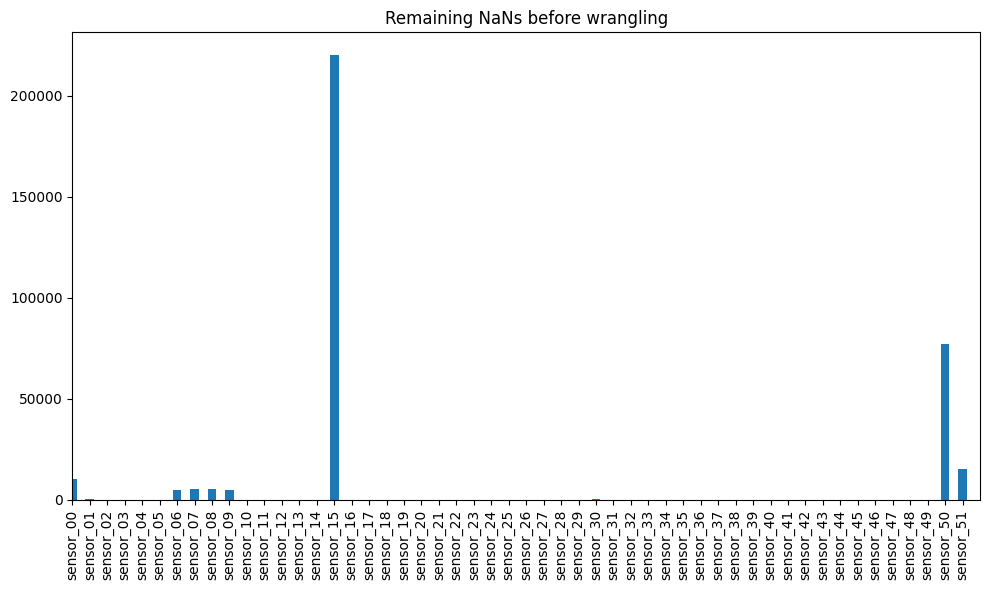

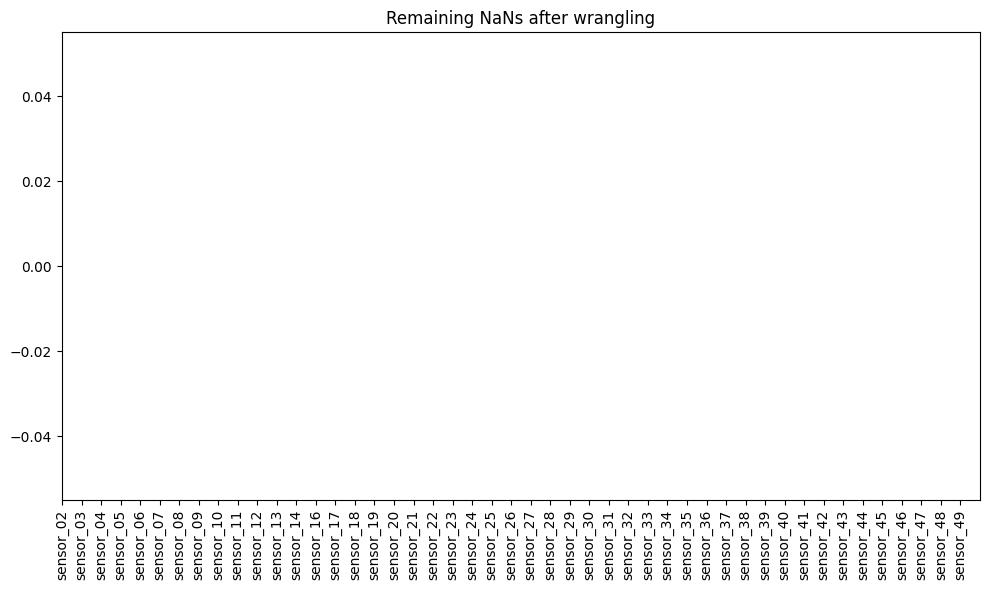

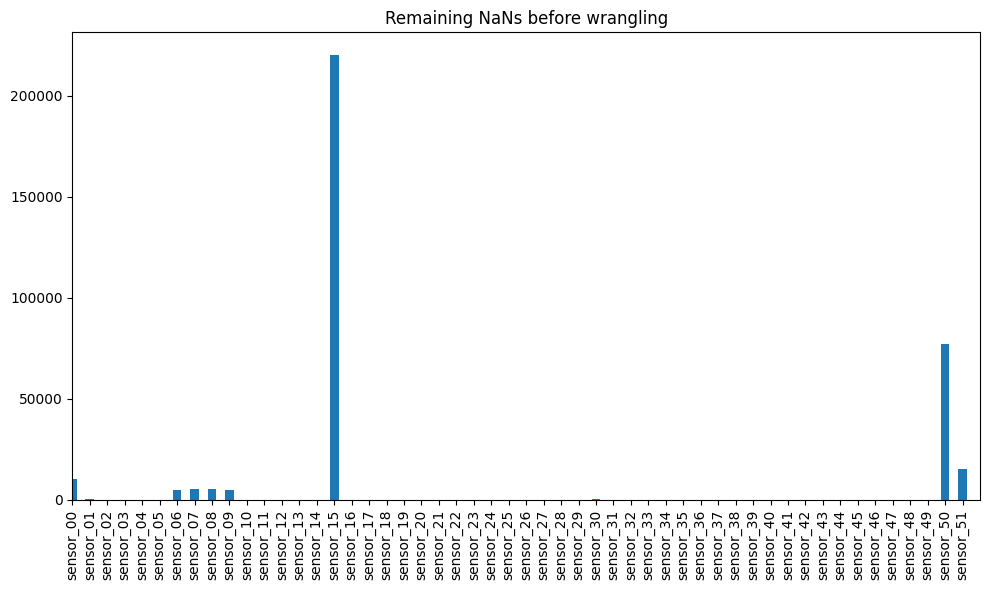

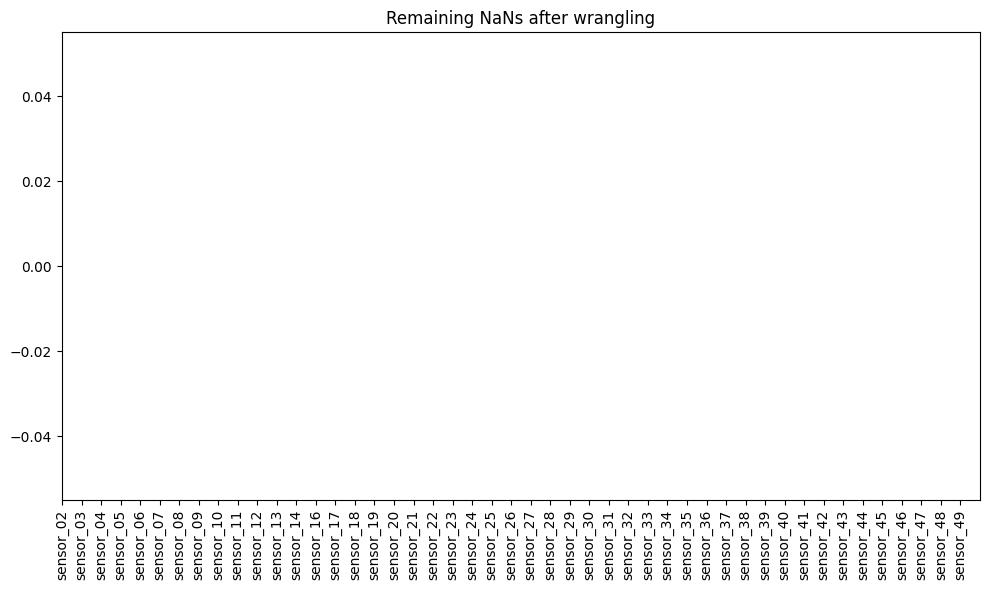

In [24]:
def wrangle_data(data, remove_columns = ['sensor_15','sensor_50'], copy_range = [slice(114900,135000)], copy_from = [50], copy_to= [51], fill_limit = 10000, plot=False):
    """
    Function shows NaN's before and after wrangling. Wrangling supports removing columns, copying parts from one column to another and filling NaNs.
    remove_columns: list of column names to be removed
    copy_range: list of indices ranges to be copied, list must have same length as copy_from and copy_to
    copy_from: list of column names from where to take the copy_range and apply it to the copy_to columns
    copy_to: list of column names where to copy the copy_range from the copy_from columns.
    Note copy commands are executed by list order always using the i-th element of all lists at the same time.
    """
    if len(copy_range) != len(copy_from) or len(copy_from) != len(copy_to):
        print("Copy instructions don't have equal length, no wrangling was applied")
        return data
    if plot==True:
        print((data.isna().sum()))
        plot_continuous_data((data.isna().sum()),'bar','Remaining NaNs before wrangling',save=False)
        plt.tight_layout()
    for i in range(0,len(copy_range)):
        data.iloc[copy_range[i],[copy_to[i]]]=data.iloc[copy_range[i],[copy_from[i]]]
    data=data.drop(labels=remove_columns,axis=1)


    data=data.ffill(limit=fill_limit)
    if plot==True:
        print((data.isna().sum()))
        plot_continuous_data((data.isna().sum()[2:-1]),'bar','Remaining NaNs after wrangling',save=False)

        plt.tight_layout()
    return data

wrangled_data = wrangle_data(variable_data, plot=True)
wrangled_scaled_data = wrangle_data(scaled_data, plot=True)

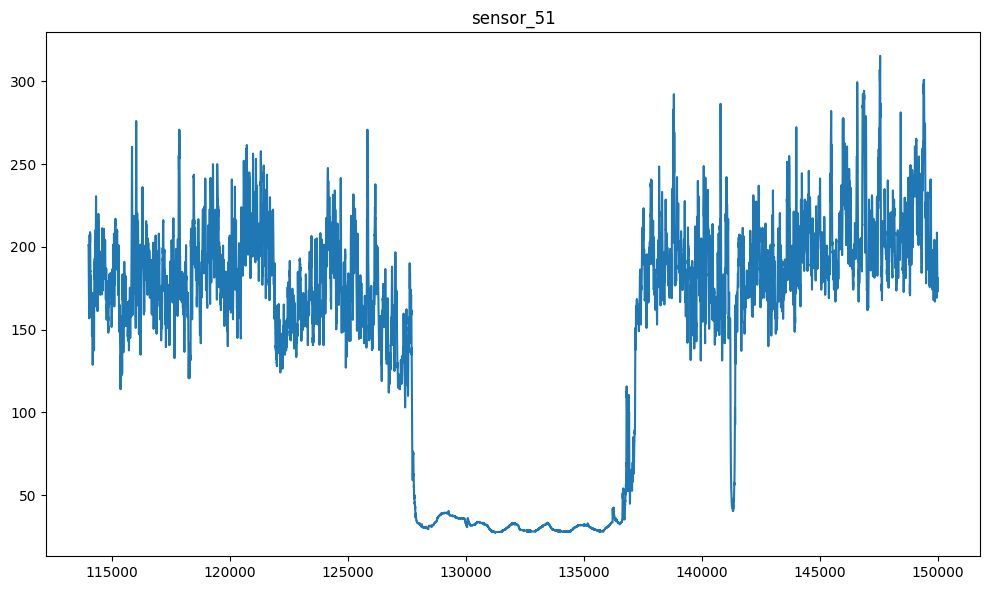

In [25]:
plot_continuous_data(wrangled_data['sensor_51'][114000:150000],'line',str('sensor_51'),scale_x_limit=False)

plt.tight_layout()

We can see that there a no more NaNs in the sensor 51. In this context, it was feasible to fix the whole with data from another sensor but that may not always be the case. The choice for fixing data is more an art than a science and requires lots of experience. Because we don't want to create a fake signal that our algorithms pick up.

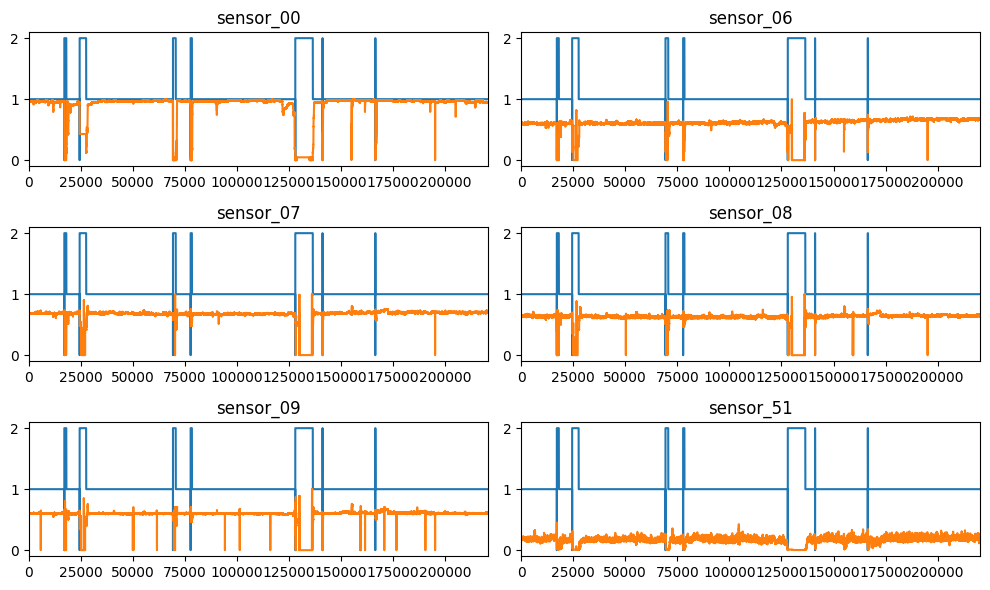

In [26]:
fig, axes = plt.subplots(nrows=3, ncols=2,)
plot_continuous_data(encoded_target_data['target'],'line',"Target",axis = axes[0,0],without_legend = False)
plot_continuous_data(wrangled_scaled_data['sensor_00'],'line',str('sensor_00'),scale_x_limit=False,axis = axes[0,0])
plot_continuous_data(encoded_target_data['target'],'line',"Target",axis = axes[0,1],without_legend = False)
plot_continuous_data(wrangled_scaled_data['sensor_06'],'line',str('sensor_06'),scale_x_limit=False,axis = axes[0,1])
plot_continuous_data(encoded_target_data['target'],'line',"Target",axis = axes[1,0],without_legend = False)
plot_continuous_data(wrangled_scaled_data['sensor_07'],'line',str('sensor_07'),scale_x_limit=False,axis = axes[1,0])
plot_continuous_data(encoded_target_data['target'],'line',"Target",axis = axes[1,1],without_legend = False)
plot_continuous_data(wrangled_scaled_data['sensor_08'],'line',str('sensor_08'),scale_x_limit=False,axis = axes[1,1])
plot_continuous_data(encoded_target_data['target'],'line',"Target",axis = axes[2,0],without_legend = False)
plot_continuous_data(wrangled_scaled_data['sensor_09'],'line',str('sensor_09'),scale_x_limit=False,axis = axes[2,0])
plot_continuous_data(encoded_target_data['target'],'line',"Target",axis = axes[2,1],without_legend = False)
plot_continuous_data(wrangled_scaled_data['sensor_51'],'line',str('sensor_51'),scale_x_limit=False,axis = axes[2,1])
plt.tight_layout()

We can see that the fill NaNs is reasonable. We have a signal that is down when the recovering is happening.

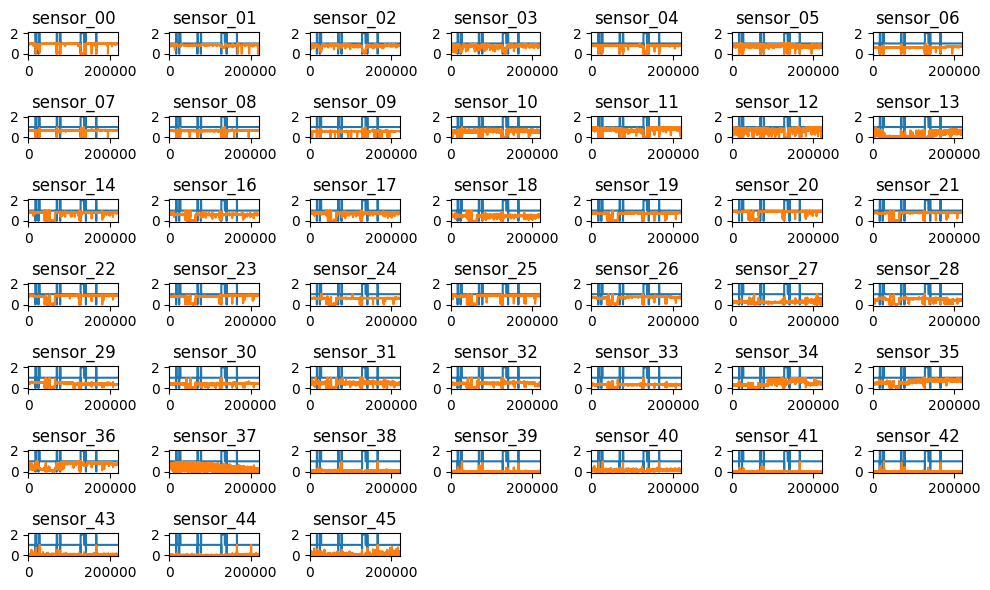

In [27]:
fig, axes = plt.subplots(nrows=7, ncols=7)
for j in range(7):
    for k in range(7):
        if (j*7+k<45):
            plot_continuous_data(encoded_target_data['target'],'line',"Target",axis = axes[j,k],without_legend = False)
            plot_continuous_data(wrangled_scaled_data.iloc[:,j*7+k],'line',wrangled_scaled_data.iloc[:,j*7+k].name,axis = axes[j,k])
for ax in axes[6,3:7]:
    ax.set_axis_off()

plt.tight_layout()

Now we can see the scaled data compared to the target function.

Before we start with the prediction, we need to understand how to format the data in the data wrangling slide deck on brightspace.

# Prediction

Object-Oriented Programming (OOP) has the advantage that repetive steps on similar objects can be generalised and simplified.

In the first part, we have created functions that can be reused for new data. OOP helps us to shift the focus from "how to do a task" to "why to do a task". We will create three classes of objects today, data, machine-learning models and machine-learning ensemble.

Instead of running a chain of complex functions or many lines of code manually, we group them logically by the object that they refer to and ask the object "to do things".

The OOP slide deck on brightspace will help you to get the basic of object orientation before you create classes.

### Class for data

The data class stores our raw data and goal function and arranges them suitably for prediction task. Categorical variables can be converted to numeric. Data can be normalised to account for the different weight of dispersing scales of variables. The data can be shifted according to our prediction needs.

In [28]:
class Data:
    """
    Represents a machine learning data set with a set of independent variables (X) and a target (dependent variable / Y).
    """

    def __init__(self, data_x, data_y, rescale = False, ANN = False, OneHot = False):
        self.data_x=data_x
        self.data_y=data_y
        self.encoded_y=[]
        if (OneHot):
            self.one_hot()
        if (rescale):
            self.scale()
        if (ANN):
            self.reshape_for_ANN()

    def shift(self,n_in,n_skip,n_out):
        """
        Takes an X and Y and re-arranges them for a time series to look ahead `n_skip` time steps for n_out time steps of Y using `n_in` time steps back of X.
        """
        self.data_x_raw=self.data_x
        self.data_y_raw=self.data_y
        self.n_in=n_in
        self.n_skip = n_skip
        self.n_out=n_out

        n_vars = self.data_x_raw.shape[1]
        cols_x, names_x = list(),list()
        cols_y, names_y = list(),list()

        # input sequence (t-n, ... t-1)
        for i in range(self.n_in+self.n_skip, self.n_skip, -1):
            cols_x.append(self.data_x_raw.shift(i))
            names_x +=[('variable_%d(t-%d)' %(j+1, i)) for j in range (n_vars)]

        agg_x = pd.concat(cols_x, axis=1)
        agg_x.columns=names_x

        #forecast sequence (t, t+1, ... t+n)
        for i in range(0, self.n_out):
            cols_y.append(self.data_y_raw.shift(-i))
            if i == 0:
                names_y +=[('target(t)')]
            else:
                names_y +=[('target(t+%d)' %(i))]

        agg_y = pd.concat(cols_y, axis=1)
        agg_y.columns=names_y

        agg = pd.concat([agg_x,agg_y],axis=1).dropna(axis='index')

        len_agg_x = agg_x.shape[1]
        self.data_x = agg.iloc[:,:len_agg_x]
        self.data_y = agg.iloc[:,len_agg_x:]

    def convert_categorical_to_numeric(self):
        """
        Converts categorical Y to numeric values.
        """
        le = preprocessing.LabelEncoder()
        le.fit(self.data_y)
        self.data_y=le.transform(self.data_y)
        self.data_y=pd.DataFrame(self.data_y,columns=['target'])
        le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))

    def splitting(self, from_index, to_index, rescale= True, ANN = True, OneHot = True):
        """
        Splits of portion of the data for an index range when random splits are not suitable.
        from_index: starting index.
        to_index: end index.
        rescale: rescales the data.
        ANN: reformats data for ANN to have 3 dimensions.
        OneHot: Splits categorical data into one-hot vectors.
        """
        split_x=self.data_x[from_index:to_index].values
        split_y=self.data_y[from_index:to_index].values
        return Data(split_x, split_y, rescale, ANN, OneHot)

    def make_float(self):
        """
        Ensures that all date is float.
        """
        self.data_x.astype('float32')

    def reshape_for_ANN(self):
        """
        Adds third dimension for ANNs, e.g. for LSTM.
        """
        self.ann_data_x=self.data_x.reshape((self.data_x.shape[0],1,self.data_x.shape[1]))

    def one_hot(self):
        """
        Transforms the numeric categorical variable into a set of "one-hot" dummy variables to ensure that categories are not interpreted linearly.
        """
        oneHot=OneHotEncoder()
        oneHot.fit(self.data_y.reshape(-1,1))
        self.oneHot=oneHot.transform(self.data_y.reshape(-1,1)).toarray()

    def scale(self,save=False):
        """
        Scales all numeric x-values.
        """
        scaler=MinMaxScaler().fit(self.data_x)
        self.data_x=scaler.transform(self.data_x)
        if save:
            savetxt('test_x_data_OOP.csv',self.data_x,delimiter='.')

## Class for Machine Learning Models

In [29]:
class MLModel(ABC):
    """
    A generic machine learning model class that provides the three basic modelling steps: creation, training, prediction and some helper functions to get a summary of the model and plotting.
    """
    def __init__(self, name = "MLModel"):
        self.name = name
        self.model = None
        self.y_hat_class = None
        self.y_hat_signal = None

    def set_data(self,training_data, validation_data, test_data):
        """
        Gives the data to the model as many models are data dependent.
        """
        self.train_data = training_data
        self.val_data = validation_data
        self.test_data = test_data

    @abstractmethod
    def create(self):
        """
        Creates the model and stores it in self.model.
        """
        pass

    @abstractmethod
    def train(self):
        """
        Trains a model with data.
        """
        pass

    @abstractmethod
    def predict(self):
        """
        Provides class and signal output in self.y_hat_class and self.y_hat_signal
        """
        pass

    @abstractmethod
    def summary(self):
        """
        Provides an overview of the model.
        """
        print(self.name + ":")

    def plot_ANN_training(self,what='loss',saving=False,name='training',axis = None):
        """
        Plot the training of an ANN showing loss or accuracy.
        """
        if axis is None:
            fig=plt.figure()
            axis = plt.gca()

        if self.history:
            axis.plot(self.history.history['class_out_'+what])
            axis.plot(self.history.history['val_class_out_'+what])
            axis.set_xlabel('epoch')
            axis.legend(['train', 'test'])
            if what=='loss':
                axis.set_title('model loss')
                axis.set_ylabel('loss')
            elif what=='acc':
                axis.set_title('model Acc')
                axis.set_ylabel('Accuracy')
            if saving==True:
                fig.savefig( name +'_'+ what + '.png', format='png', dpi=300, transparent=True)

In [30]:
class LongShortTermMemory(MLModel):
    """
    An example MLModel for a tensorflow-based ANN.
    """

    def __init__(self, nodes = 42, out_class = 3,epoch = 5, batchsize = 32):
        super().__init__()
        self.nodes = nodes
        self.out_class = out_class
        self.epoch = epoch
        self.batchsize = batchsize
        self.load_model = False
        self.show_plot = True

    def create(self):
        in_shape = self.train_data.ann_data_x.shape
        inputs= tf.keras.Input(shape=(in_shape[1],in_shape[2]))
        LSTM1=LSTM(self.nodes,activation='relu', input_shape=(in_shape[1],in_shape[2]),return_sequences=True)(inputs)
        LSTM2=LSTM(self.nodes,activation='relu')(LSTM1)
        out_signal=Dense(1, name='signal_out')(LSTM2)
        out_class=Dense(self.out_class,activation='softmax', name='class_out')(LSTM2)
        self.model = tf.keras.Model(inputs=inputs, outputs=[out_signal,out_class])
        self.model.compile(loss={'signal_out':'mean_squared_error',
                            'class_out' :'categorical_crossentropy'},
                             optimizer='adam',
                             metrics={'class_out':'acc'})

    def train(self):
        if self.load_model:
            self.model=tf.keras.models.load_model('./model/'+self.name+".keras")
        else:
            self.history = self.model.fit(self.train_data.ann_data_x,
                                          [self.train_data.data_y, self.train_data.oneHot],
                                          epochs=self.epoch,
                                          batch_size=self.batchsize,
                                          validation_data=(self.val_data.ann_data_x, [self.val_data.data_y,self.val_data.oneHot]),
                                          shuffle=False)

            if self.show_plot:
                self.plot_ANN_training(what='loss',
                              saving=True,
                              name=('training_' + str(self.name)))
                self.plot_ANN_training(what='acc',
                              saving=True,
                              name=('training_' + str(self.name)))
            self.model.save('./model/'+str(self.name)+".keras")

    def predict(self):
        [yhat,yclass] = self.model.predict(self.test_data.ann_data_x)
        self.y_hat_signal = yhat
        self.y_hat_class=[np.argmax(yclass[i],0) for i in range(len(yclass))] # get final class

    def summary(self):
        self.model.summary()


In [31]:
class RandomForest(MLModel):
    """
    An example MLModel for a sklearn-based ML model.
    """

    def __init__(self, num_trees = 100):
        super().__init__()
        self.num_trees = num_trees

    def create(self):
        self.model = RandomForestClassifier(n_estimators = self.num_trees, n_jobs=-1, warm_start = True, max_features='sqrt', verbose = 2)

    def train(self):
        self.model.fit(self.train_data.data_x, self.train_data.data_y)

    def predict(self):
        self.y_hat_signal = self.model.predict_proba(self.test_data.data_x)[:,2]+1
        self.y_hat_class = self.model.predict(self.test_data.data_x)

    def summary(self):
        pprint.pprint(self.model.get_params(), compact=True)


## Class for Machine Learning Ensemble

The MLEnsemble class loads the data, transforms it, prepares models and allows to predict based on these models.

This version implements Random Forest and an Long-Short-Term-Memory (LSTM) ANN. You can add more modells or generalise it to run any kind of model.

This class implements both classification and signal/regression results. The later is interesting to understand ROC and generally how the model works.

In [32]:
class MLEnsemble:
    def __init__(self, name, data_x, data_y, steps_into_future = 0, x_steps_for_prediction = 10,y_steps_for_prediction = 1):
        """
        The MLEnsemble uses parameters to configure the data for the model.
        """
        self.name = name

        self.data = Data(data_x, data_y)
        self.steps_into_future = steps_into_future
        self.x_steps_for_prediction = x_steps_for_prediction
        self.y_steps_for_prediction = y_steps_for_prediction

        self.data.shift(n_in = x_steps_for_prediction, n_skip = self.steps_into_future, n_out = self.y_steps_for_prediction)
        self.data.convert_categorical_to_numeric() # change Y to mapped target values
        self.data.make_float()

        self.train_data = self.data.splitting(0,120000)
        self.val_data = self.data.splitting(140000,len(self.data.data_x))
        self.test_data = self.data.splitting(120000,140000)

        self.models = dict()

    def add_model(self, name, model):
        """
        Add a MLModel to the Ensemble.
        """
        name_appendix = '_' +str(self.x_steps_for_prediction) + '_' + str(self.steps_into_future) + '_' + str(self.y_steps_for_prediction)

        key = self.name + '_' + name + name_appendix
        model.name = key
        model.set_data(self.train_data,self.val_data,self.test_data)
        self.models[key] = model

    def create_all_models(self):
        """
        Creates all the models of type MLModel.
        """
        for model in self.models.values():
            model.create()


    def summarise_all_models(self):
        """
        Summarises model parameter for all the models of type MLModel.
        """
        for model in self.models.values():
            model.summary()

    def train_all_models(self):
        """
        Trains all the models of type MLModel.
        """
        for model in self.models.values():
            model.train()

    def predict_all_models(self):
        """
        Predicts Y for all the models of type MLModel.
        """
        for model in self.models.values():
            print(model.name + ":")
            model.predict()
            self.prediction_summary(model.y_hat_class)


    def plot_all_models_prediction(self):
        """
        Compares prediction of signal and class of all the models of type MLModel.
        """
        for model in self.models.values():
            self.plot_model_prediction(model.y_hat_signal,model.y_hat_class,model.name)

    def plot_prediction(self, y, y_hat, title, name, axis = None, saving = False):
        """
        Plots the prediction for y (y_hat) against a ground truth.
        """
        if axis is None:
            fig=plt.figure()
            axis = plt.gca()

        axis.plot(y)
        axis.plot(y_hat)
        axis.legend(['target','target_predicted'],title = name)
        axis.set_ylabel('target')
        axis.set_title(title)

        if saving==True:
            fig.savefig( name +'.png', format='png', dpi=300, transparent=True)

    def plot_model_prediction(self, y_hat_signal, y_hat_class, name = 'ML Model'):
        """
        Compares prediction of signal and class of a machine learning model.
        """
        fig, axes = plt.subplots(nrows=1, ncols=2)
        self.plot_prediction(self.test_data.data_y, y_hat_signal, 'Prediction of signal', name,axis = axes[0])
        self.plot_prediction(self.test_data.data_y, y_hat_class, 'Prediction of class', name,axis = axes[1])
        plt.tight_layout()
        fig.savefig(name+'.png', format='png', dpi=300, transparent=True)

    def prediction_summary(self, y_hat):
        """
        Produces standard metrics like confusion matrix, accuracy, precision and recall.
        """
        y = self.test_data.data_y.ravel()
        cm = confusion_matrix(y, np.array(y_hat))
        accuracy = accuracy_score(y, np.array(y_hat))
        precision = precision_score(y, np.array(y_hat), average = 'weighted')
        recall = recall_score(y, np.array(y_hat), average = 'weighted')
        print("Confusion Matrix:", cm)
        print("Accuracy:", accuracy)
        print("Precision:", precision)
        print("Recall:", recall)


## Prediction

We only use the last 10 minutes with no look ahead to predict the next minute.

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 1, 500)         │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ (None, 1, 42)          │         91,224 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ (None, 42)             │         14,280 │ lstm[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ signal_out (Dense)        │ (None, 1)              │             43 │ lstm_1[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ class_out (Dense)         │ (None, 3)              │            129 │ lstm_1[0][0]           │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 105,676 (412.80 KB)

 Trainable params: 105,676 (412.80 KB)

 Non-trainable params: 0 (0.00 B)

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 10,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': None,
 'verbose': 2,
 'warm_start': True}
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/losses/losses.py:27: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(32, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return self.fn(y_true, y_pred, **self._fn_kwargs)


3749/3750 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - class_out_acc: 0.7477 - class_out_loss: 0.1708 - loss: 0.1708 - signal_out_loss: 1.2669e-07

/usr/local/lib/python3.10/dist-packages/keras/src/losses/losses.py:27: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return self.fn(y_true, y_pred, **self._fn_kwargs)


3750/3750 ━━━━━━━━━━━━━━━━━━━━ 38s 9ms/step - class_out_acc: 0.7477 - class_out_loss: 0.1708 - loss: 0.1708 - signal_out_loss: 1.2669e-07 - val_class_out_acc: 0.9985 - val_class_out_loss: 9.7941e-04 - val_loss: 9.7973e-04 - val_signal_out_loss: 1.1938e-07
Epoch 2/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 35s 9ms/step - class_out_acc: 0.8811 - class_out_loss: 0.0758 - loss: 0.0758 - signal_out_loss: 1.2669e-07 - val_class_out_acc: 0.9937 - val_class_out_loss: 0.0028 - val_loss: 0.0028 - val_signal_out_loss: 1.1938e-07
Epoch 3/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 38s 8ms/step - class_out_acc: 0.9792 - class_out_loss: 0.0135 - loss: 0.0135 - signal_out_loss: 1.2669e-07 - val_class_out_acc: 0.9977 - val_class_out_loss: 0.0012 - val_loss: 0.0012 - val_signal_out_loss: 1.1938e-07
Epoch 4/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 37s 7ms/step - class_out_acc: 0.9849 - class_out_loss: 0.0083 - loss: 0.0083 - signal_out_loss: 1.2669e-07 - val_class_out_acc: 0.9962 - val_class_out_loss: 0.0016 - val_loss: 0.0016 -

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 10
building tree 2 of 10
building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   21.8s finished


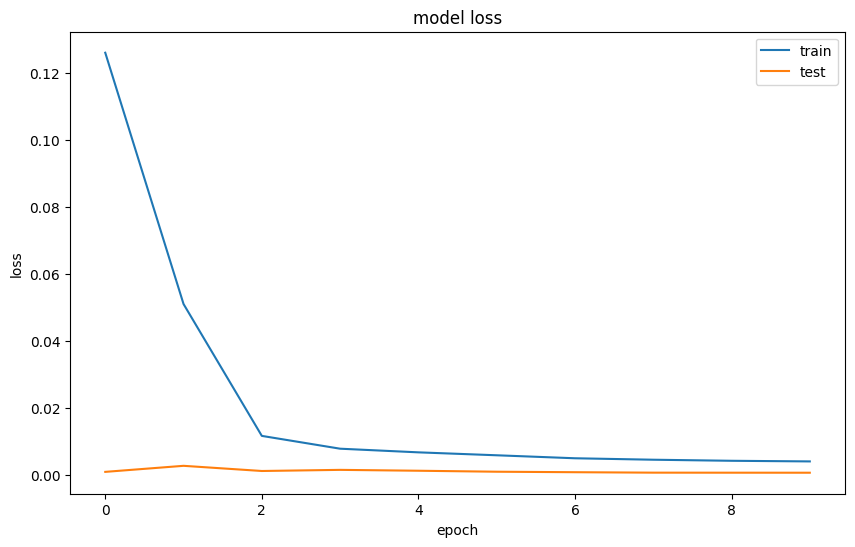

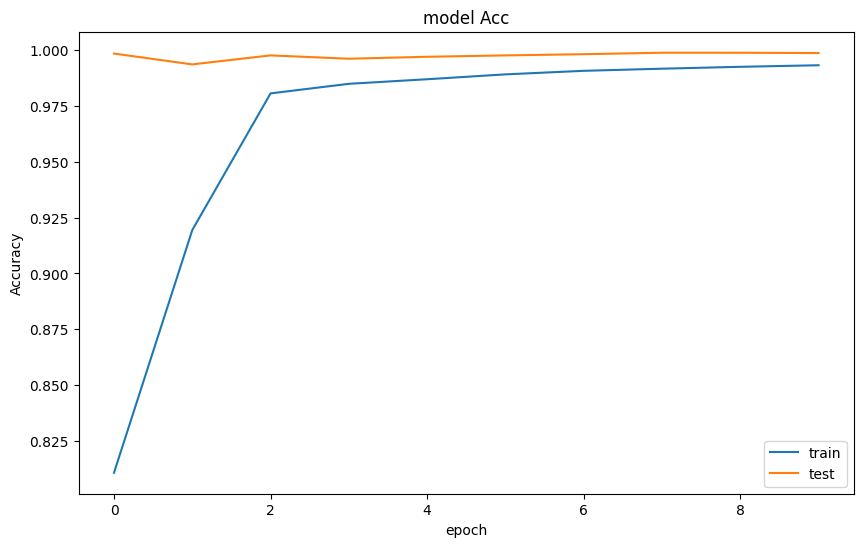

In [33]:
MLEnsemble1 = MLEnsemble("Ensemble",wrangled_scaled_data, encoded_target_data['target'],0,10,1)

MLEnsemble1.add_model('LSTM',LongShortTermMemory(epoch = 10))
MLEnsemble1.add_model('RF',RandomForest(num_trees =10))

MLEnsemble1.create_all_models()

MLEnsemble1.summarise_all_models()

MLEnsemble1.train_all_models()

Ensemble_LSTM_10_0_1:
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.0s finished


Confusion Matrix: [[    0     1     0]
 [    0 11476   133]
 [    0  2606  5784]]
Accuracy: 0.863
Precision: 0.8830695929949379
Recall: 0.863
Ensemble_RF_10_0_1:
Confusion Matrix: [[    0     0     1]
 [   12 11238   359]
 [    0   939  7451]]
Accuracy: 0.93445
Precision: 0.9358557253560804
Recall: 0.93445


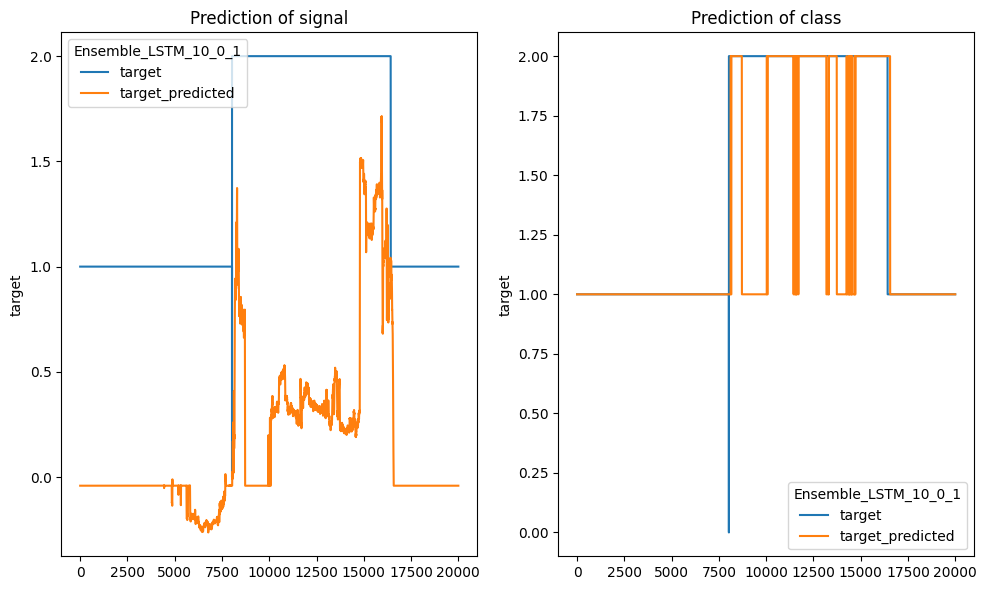

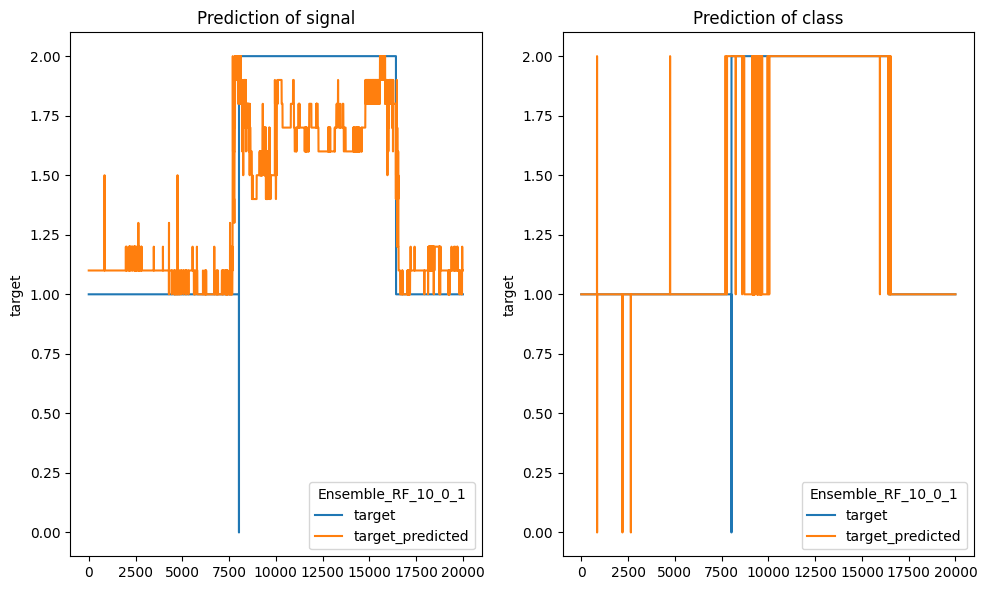

In [34]:
MLEnsemble1.predict_all_models()
MLEnsemble1.plot_all_models_prediction()

### Finding parameters

How far into the future can you reliably predict that the target will break and recover?

In [35]:
#Place your own code here

#Hint create your own MLEnsemble with different parameters and add models with different parameters



#Then follow the classical steps of running an ML model. If your Ensemble has a different name you have to adjust the code below
#YourEnsemble.create_all_models()

#YourEnsemble.summarise_all_models()

#YourEnsemble.train_all_models()

#YourEnsemble.predict_all_models()

#YourEnsemble.plot_all_models_prediction()


### Adding your own MLModel

Use the template below to add your another MLModel to the Ensemble. You can always check the random forest and the LSTM above to see how to write these functions.

In [36]:
class ChangeMyName(MLModel):
    def __init__(self, add_new_parameters_here = 'replace_me'):
        super().__init__()
        self.replace_me = add_new_parameters_here
        #Put all the parameters to configure your model here!

    def create(self):
        #If you have an ANN you need to create the components here before you place it in the model. Take a look at the LSTM example above.
        self.model = "Put your model object here"
        #ANNs need compilation, don't forget to put it here if you create an ANN.

    def train(self):
        #Call the fitting function of your model here:


        #You can find the in self.train_data and for validation in self.val_data
        #Here are some examples of these data to help you get started
        self.train_data.ann_data_x #for tensorflow ANNs
        self.train_data.data_x #for sklearn models
        [self.train_data.data_y, self.train_data.oneHot] #Y for anns with signal and class you need both the raw result the the one hot!
        self.train_data.data_y #for sklearn models

    def predict(self):
        #Call the predict function of your model and produce a class and signal output and store them in

        #Store the results in these two variables for the Ensemble to work with them
        self.y_hat_signal = "your signal data goes here"
        self.y_hat_class= "your class data goes here"

    def summary(self):
        #Add your model summary below
        print("I am not really a summary but oh well ...")


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 1, 500)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_2 (LSTM)             │ (None, 1, 42)          │         91,224 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_3 (LSTM)             │ (None, 42)             │         14,280 │ lstm_2[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ signal_out (Dense)        │ (None, 1)              │             43 │ lstm_3[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ class_out (Dense)         │ (None, 3)              │            129 │ lstm_3[0][0]           │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 105,676 (412.80 KB)

 Trainable params: 105,676 (412.80 KB)

 Non-trainable params: 0 (0.00 B)

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': None,
 'verbose': 2,
 'warm_start': True}
Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/losses/losses.py:27: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(32, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return self.fn(y_true, y_pred, **self._fn_kwargs)


3747/3750 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - class_out_acc: 0.7467 - class_out_loss: 0.1720 - loss: 0.1720 - signal_out_loss: 1.2669e-07

/usr/local/lib/python3.10/dist-packages/keras/src/losses/losses.py:27: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return self.fn(y_true, y_pred, **self._fn_kwargs)


3750/3750 ━━━━━━━━━━━━━━━━━━━━ 34s 8ms/step - class_out_acc: 0.7468 - class_out_loss: 0.1719 - loss: 0.1719 - signal_out_loss: 1.2669e-07 - val_class_out_acc: 0.9985 - val_class_out_loss: 0.0010 - val_loss: 0.0010 - val_signal_out_loss: 1.1938e-07
Epoch 2/30
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 32s 9ms/step - class_out_acc: 0.9354 - class_out_loss: 0.0419 - loss: 0.0419 - signal_out_loss: 1.2669e-07 - val_class_out_acc: 0.9985 - val_class_out_loss: 9.8765e-04 - val_loss: 9.8789e-04 - val_signal_out_loss: 1.1938e-07
Epoch 3/30
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 29s 8ms/step - class_out_acc: 0.9619 - class_out_loss: 0.0255 - loss: 0.0255 - signal_out_loss: 1.2669e-07 - val_class_out_acc: 0.9980 - val_class_out_loss: 0.0012 - val_loss: 0.0012 - val_signal_out_loss: 1.1938e-07
Epoch 4/30
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 42s 8ms/step - class_out_acc: 0.9853 - class_out_loss: 0.0090 - loss: 0.0090 - signal_out_loss: 1.2669e-07 - val_class_out_acc: 0.9985 - val_class_out_loss: 8.6754e-04 - val_loss: 8.67

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.1min


building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.2min finished


Ensemble_LSTM_10_0_1:
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished


Confusion Matrix: [[    0     1     0]
 [    0 11424   185]
 [    0  1322  7068]]
Accuracy: 0.9246
Precision: 0.9290055461683638
Recall: 0.9246
Ensemble_RF_10_0_1:


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Confusion Matrix: [[    0     0     1]
 [    0 11241   368]
 [    0     0  8390]]
Accuracy: 0.98155
Precision: 0.9822772633862312
Recall: 0.98155


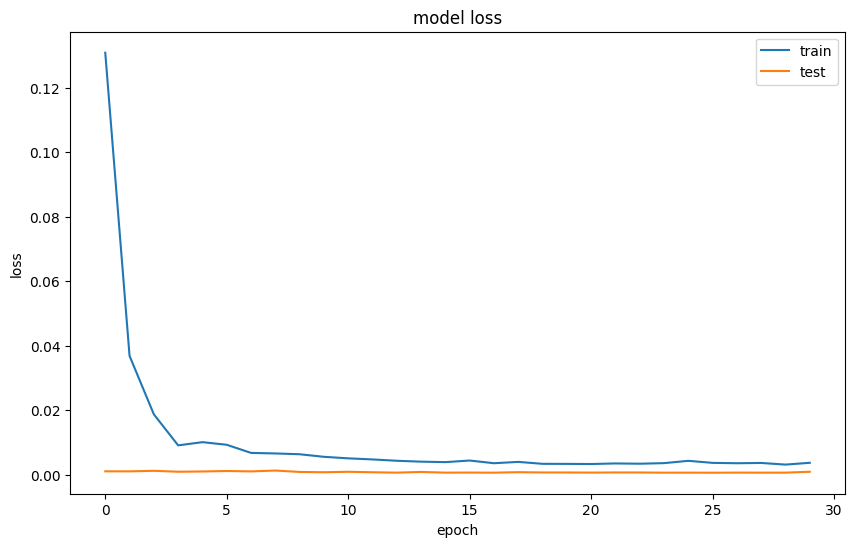

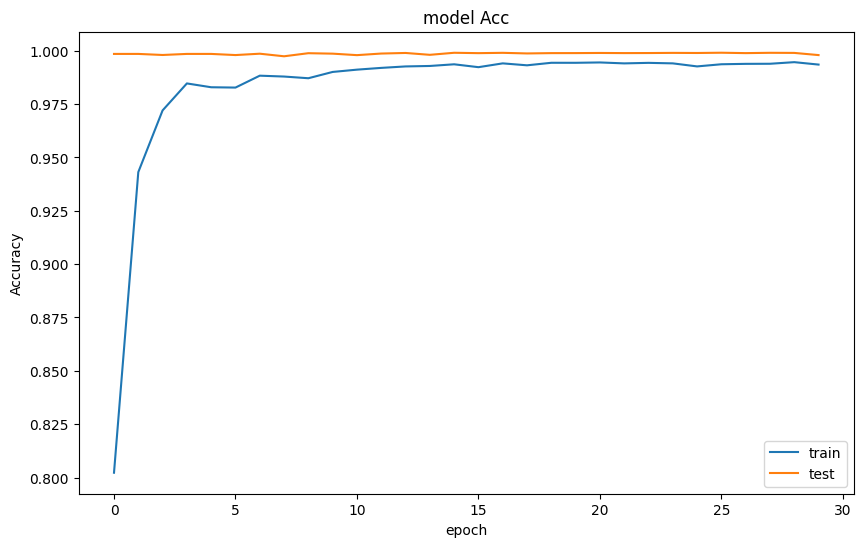

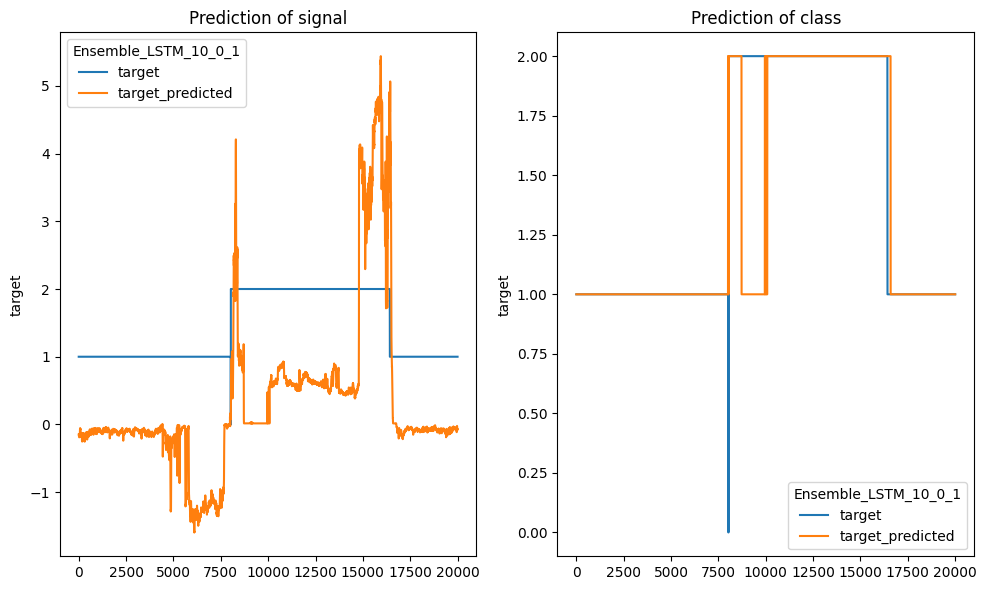

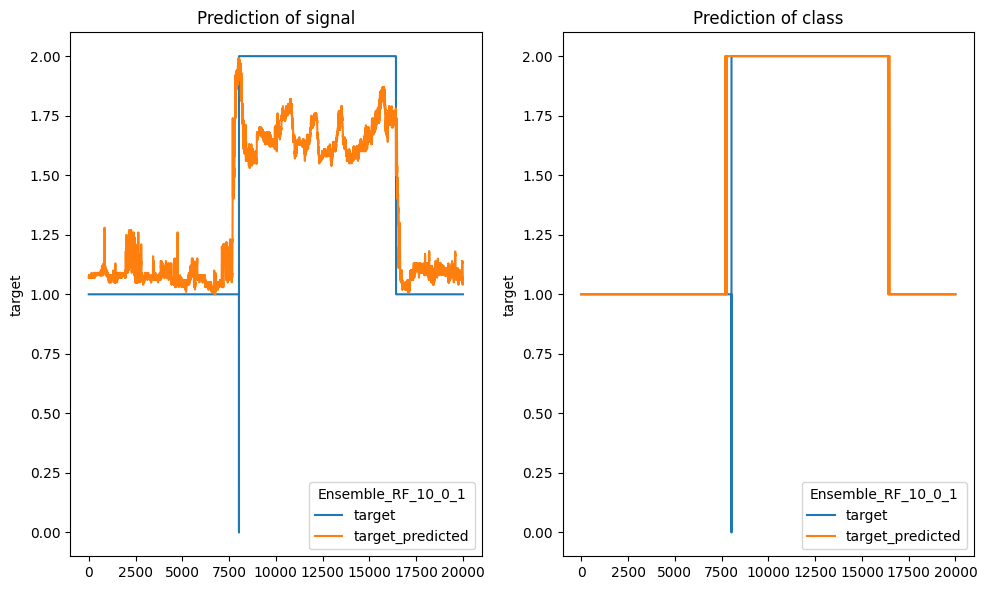

In [38]:
MLEnsemble2 = MLEnsemble("Ensemble",wrangled_scaled_data, encoded_target_data['target'],0,10,1)#You could also change the parameters

MLEnsemble2.add_model('LSTM',LongShortTermMemory(epoch = 30))#You could also change the parameters
MLEnsemble2.add_model('RF',RandomForest(num_trees =100))#You could also change the parameters
#Add your own MLModel here!

MLEnsemble2.create_all_models()

MLEnsemble2.summarise_all_models()

MLEnsemble2.train_all_models()

MLEnsemble2.predict_all_models()

MLEnsemble2.plot_all_models_prediction()